# Individual sensor permutation tests

The heterogeneity figure in the paper is striking. Is it to be trusted, or is there just so much noise in the data that it's unsurprising? The overall numbers are based on the full dataset, but that figure is per-sensor. Under a null hypothesis of no difference between sensors, what is the variance of a similar plot?

We do this by doing permutation tests for each sensor and computing 1000 realizations of the mean difference. We use these to compute 1000 realizations of the variance of the per-sensor heterogeneity, and compare to the variance of the observed distribution. The permutation test forces the "true" value of the difference for each sensor to be identically 0. It's okay that in the data the "true" value if there were no heterogeneity is -0.56; we're only looking at the variance so a global shift will fall out.

In [1]:
using KFactors, DataFrames, ThreadsX, Pipe, StatsBase, Random, Plots

┌ Info: Precompiling KFactors [ed362b46-60d5-416f-85cf-bff05ff5e122]
└ @ Base loading.jl:1662


In [2]:
raw_data = KFactors.read_data("../data/peaks_merged.parquet");

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.83%)
└ @ KFactors C:\Users\mwbc\git\peak-spreading\src\computation.jl:65


In [3]:
data = KFactors.create_test_data(raw_data, KFactors.Periods.SPRING_2022);

In [4]:
data = data[data.period .∈ Ref(Set([:prepandemic, :postlockdown])), :];

In [7]:
# permutation test is simpler here, since we're doing it per sensor - no need to block bootstrap
# as each per-sensor observation is independent

results = zeros(Float64, 1000, length(sensors))

data.sensor_id = map(id -> findfirst(sensors .== id), data.station)

# barrier function for type stability
function _update(stations, values, results, permutation)
    for (station, value) in zip(stations, values)
        results[permutation, station] = value
    end
end

function sensor_permutations(occ, period)
    permuted_period = Random.shuffle(period)
    mean(@view occ[permuted_period .== :postlockdown]) - mean(@view occ[permuted_period .== :prepandemic])
end

for permutation in collect(1:1000)
    res = @pipe groupby(data, :sensor_id) |>
        combine(_, [:peak_hour_occ, :period] => sensor_permutations => :Δpeak_hour_occ)
    _update(res.sensor_id, res.Δpeak_hour_occ, results, permutation)
end

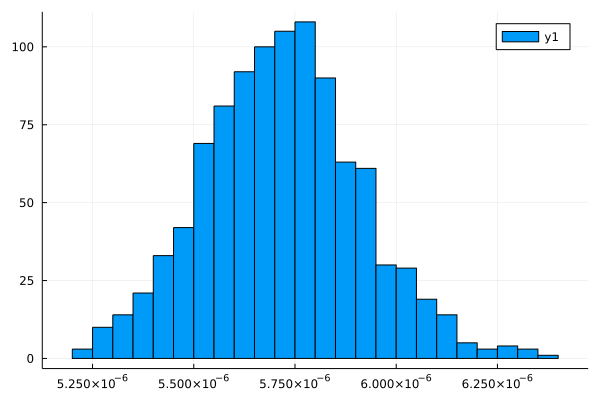

In [14]:
# Results contains 1000 permutations of differences with 
variances = dropdims(var(results, dims=2), dims=2)
histogram(variances)

In [16]:
# compute variance for the observed distribution
test_stat = @pipe groupby(data, :station) |>
    combine(_, [:peak_hour_occ, :period] =>
        ((occ, period) -> mean(@view occ[period .== :postlockdown]) - mean(@view occ[period .== :prepandemic])) =>
        :obs_diff) |>
    var(_.obs_diff)


0.0002563138411239278

In [19]:
# compute the p-value.
(1 - mean(test_stat .> variances)) * 2

0.0

## Conclusion

This bootstrapped distribution is much tighter than the observed distribution. Not the (sole) explanation for heterogeneity.